<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting/blob/main/myStocks_Chart_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mplfinance
import mplfinance as mpf

In [2]:
import pandas as pd
import mplfinance as mpf
import yfinance as yfin
#import talib
yfin.pdr_override()

def get_chart(symbol, tf):
  if tf == 'D':
    intvl, sma, lma, xlma, prd, start_date, tfc = '1d', 20, 50, 200, '2y', '2023-01-01','Daily'
  elif tf == 'W':
    intvl, sma, lma, xlma, prd, start_date, tfc = '1wk', 5, 10, 30, '6y', '2019-01-01','Weekly'
  else:
    intvl, sma, lma, xlma, prd, start_date, tfc = '1mo', 2, 5, 10, '10y', '2013-01-01','Monthly'

  # Sample data with OHLCV (Open, High, Low, Close, Volume) prices
  # Sample data
  df = yfin.Ticker(symbol+'.NS').history(period=prd, interval=intvl)[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
  #df.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
  #df = pd.DataFrame(data)
  #df.set_index('Date', inplace=True)

  # Calculate moving averages
  df['MA_short'] = df['Close'].rolling(window=sma).mean()
  df['MA_long'] = df['Close'].rolling(window=lma).mean()
  df['MA_xlong'] = df['Close'].rolling(window=xlma).mean()

  df = df[df.index >= start_date]
  col = tf + '_' + 'Flag'
  df[col] = 'R'
  df.loc[df['MA_short'] > df['MA_long'], col] = 'G'
  df = df[df.index > '31-Jan-2023']


  where_values1 = df['MA_short'].values>df['MA_long'].values
  where_values2 = df['MA_short'].values<df['MA_long'].values

  apds = [ mpf.make_addplot(df['MA_xlong'], color='dimgrey', linestyle='dashed'),
          mpf.make_addplot(df[['MA_short', 'MA_long']], fill_between=dict(y1=df['MA_short'].values,y2=df['MA_long'].values, where=where_values1, color='paleturquoise', alpha = .3), alpha = 0),
          mpf.make_addplot(df[['MA_short', 'MA_long']], fill_between=dict(y1=df['MA_short'].values,y2=df['MA_long'].values, where=where_values2, color='lightcoral', alpha = .3), alpha = 0)
        ]

  cols = ['Open', 'Close', 'Low', 'High', 'Volume']
  # Plot the candlestick chart with volume
  mpf.plot(df[cols], type='candle', style='yahoo', volume=True, addplot=apds, figsize=(18, 6), title=symbol+ ' - ' + tfc )

  # If you want to save the plot to a file, use the following line
  # mpf.plot(df, type='candle', style='yahoo', volume=True, title='Candlestick Chart with Volume', savefig='chart.png')

  mpf.show()
  cols = [col]
  #return df[df.index > '31-Jan-2023'][cols]

In [3]:
import pandas as pd
import mplfinance as mpf
import yfinance as yfin
#import talib
yfin.pdr_override()

def get_mtm_data(symbol, tf):
  if tf == 'D':
    intvl, sma, lma, xlma, prd, start_date, tfc = '1d', 20, 50, 200, '2y', '2023-01-01','Daily'
  elif tf == 'W':
    intvl, sma, lma, xlma, prd, start_date, tfc = '1wk', 5, 10, 30, '6y', '2019-01-01','Weekly'
  else:
    intvl, sma, lma, xlma, prd, start_date, tfc = '1mo', 2, 5, 10, '10y', '2013-01-01','Monthly'

  # Sample data with OHLCV (Open, High, Low, Close, Volume) prices
  # Sample data
  df = yfin.Ticker(symbol+'.NS').history(period=prd, interval=intvl)[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
  #df.drop(['Open', 'Low', 'High', 'Volume'], axis=1, inplace=True)
  #df = pd.DataFrame(data)
  #df.set_index('Date', inplace=True)

  # Calculate moving averages
  df['MA_short'] = df['Close'].rolling(window=sma).mean()
  df['MA_long'] = df['Close'].rolling(window=lma).mean()
  df['MA_xlong'] = df['Close'].rolling(window=xlma).mean()

  df = df[df.index >= start_date]
  col = tf + '_' + 'Flag'
  df[col] = 'R'
  df.loc[df['MA_short'] > df['MA_long'], col] = 'G'
  df = df[df.index > '31-Jan-2023']
  cols = [col]
  return df[df.index > '31-Jan-2023'][cols]

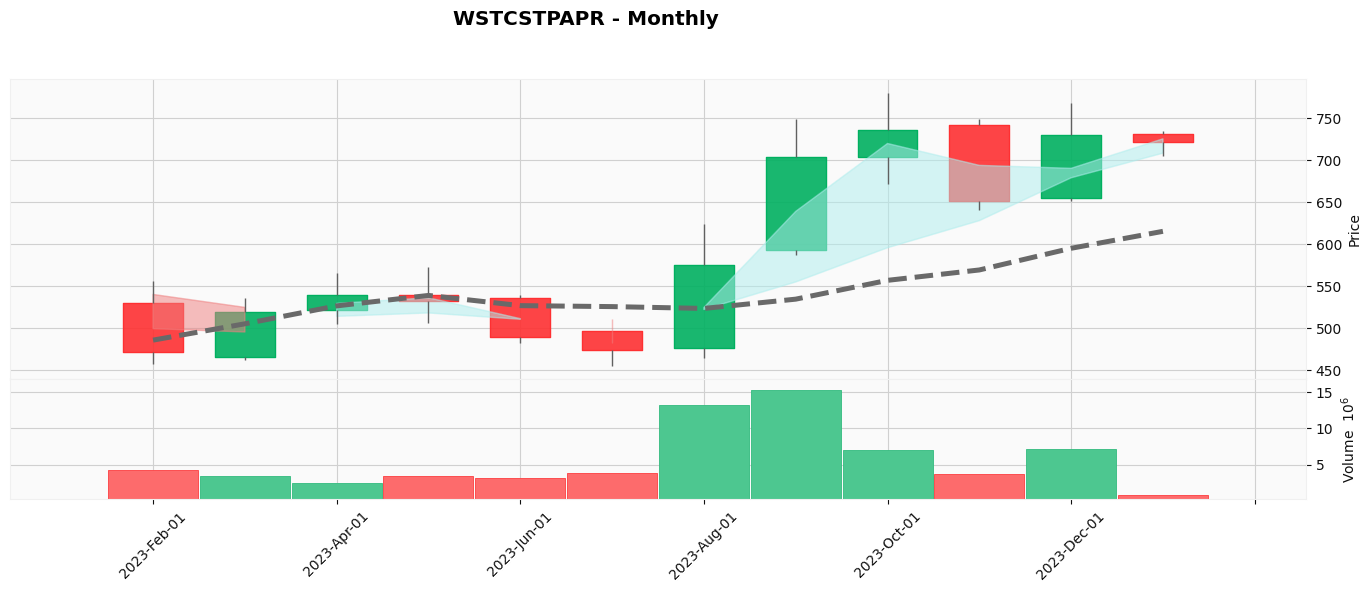

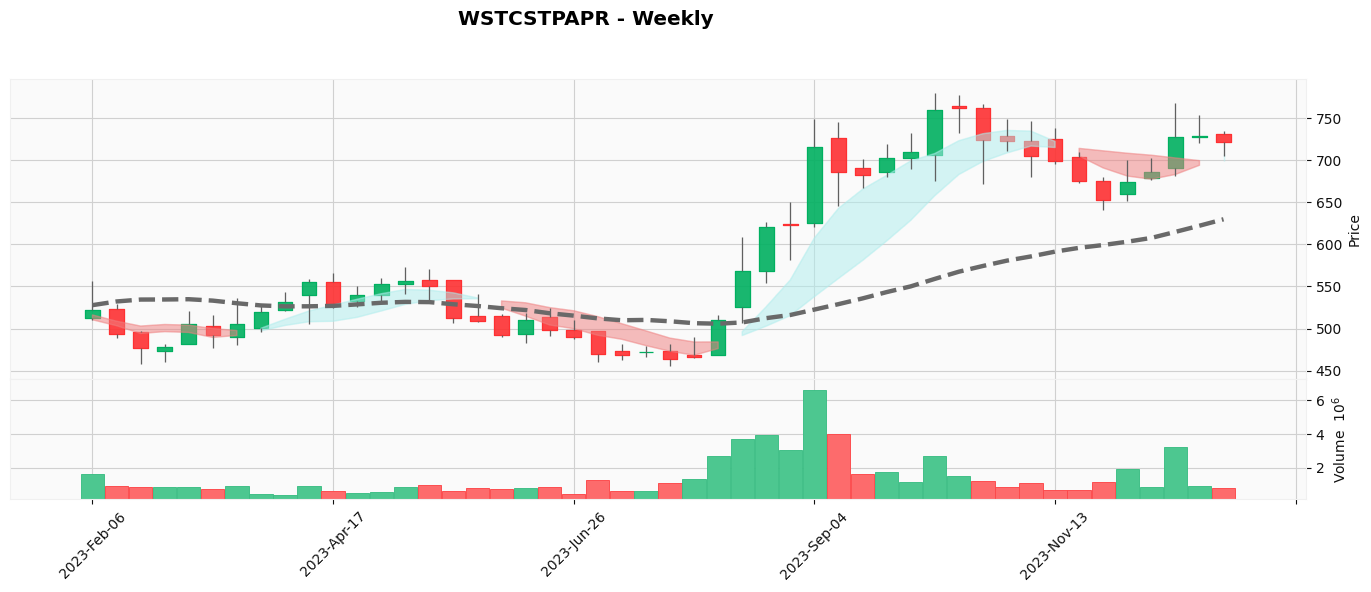

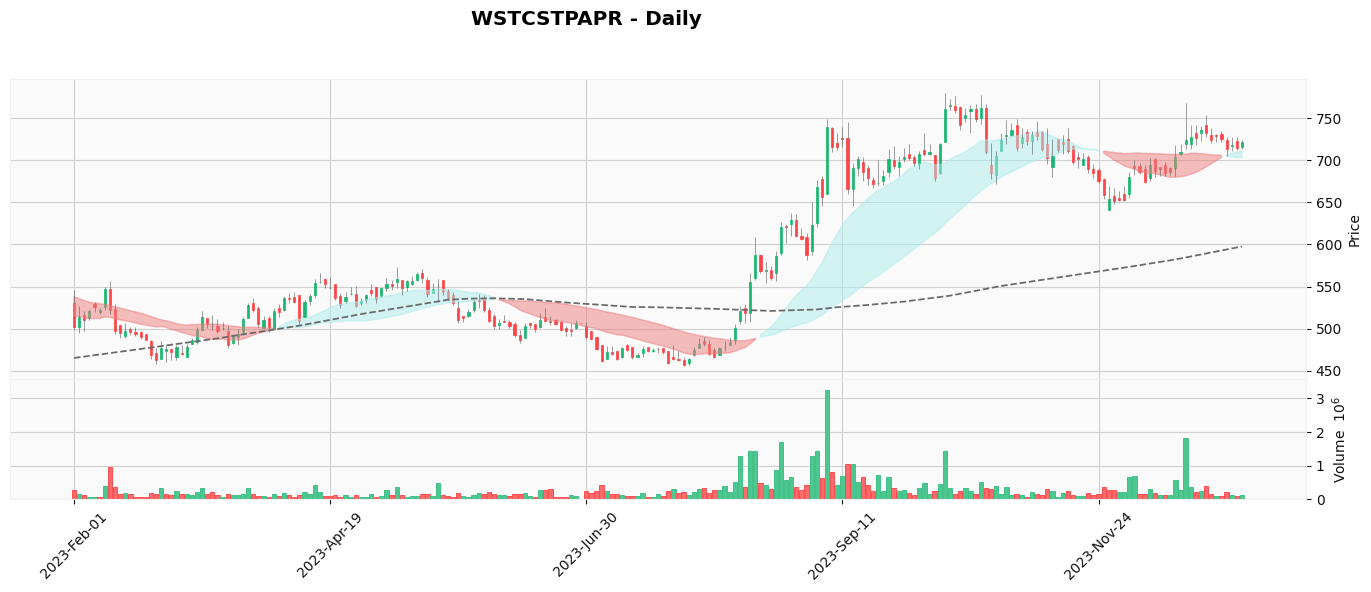

In [9]:
symbol = 'WSTCSTPAPR'
get_chart(symbol, 'M')
get_chart(symbol, 'W')
get_chart(symbol, 'D')

In [10]:
m_df = get_mtm_data(symbol, 'M')
w_df = get_mtm_data(symbol, 'W')
d_df = get_mtm_data(symbol, 'D')

In [11]:
m_df['month'] = m_df.index.month
w_df['week'] = w_df.index.week
d_df['week'] = d_df.index.week
d_df['month'] = d_df.index.month
d_df = d_df.reset_index()
cmb_df = pd.merge(d_df, w_df, on='week', how='outer')
cmb_df = pd.merge(cmb_df, m_df, on='month', how='outer')
cols = ['Date','D_Flag','W_Flag','M_Flag']
cmb_df = cmb_df[cols]
cmb_df.set_index('Date', inplace=True)

<ipython-input-11-1bf792a8a7a3>:2: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  w_df['week'] = w_df.index.week
<ipython-input-11-1bf792a8a7a3>:3: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  d_df['week'] = d_df.index.week


In [12]:
df = yfin.Ticker(symbol+'.NS').history(period='1y', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
df = df.join(cmb_df)
df['F_Flag'] = 'R'
df['G_Close'] = df['Close'].min()
df.loc[(df['D_Flag'] == 'G') & (df['W_Flag'] == 'G') & (df['M_Flag'] == 'G'), 'F_Flag'] = 'G'
df.loc[(df['F_Flag'] == 'G'), 'G_Close'] = df['Close'].max()
df

,Open,Close,Low,High,Volume,D_Flag,W_Flag,M_Flag,F_Flag,G_Close
Date,,,,,,,,,,
2023-01-05 00:00:00+05:30,526.991219,538.941589,525.032144,544.378011,305880,NaN,NaN,NaN,R,456.464508
2023-01-06 00:00:00+05:30,541.390431,533.994934,529.342131,541.586350,87810,NaN,NaN,NaN,R,456.464508
2023-01-09 00:00:00+05:30,536.933554,532.525635,529.293113,548.541050,187939,NaN,NaN,NaN,R,456.464508
2023-01-10 00:00:00+05:30,531.888895,518.126404,515.236756,531.888895,84494,NaN,NaN,NaN,R,456.464508
2023-01-11 00:00:00+05:30,519.154882,514.697998,512.640933,521.016027,59232,NaN,NaN,NaN,R,456.464508
...,...,...,...,...,...,...,...,...,...,...
2024-01-01 00:00:00+05:30,731.200012,724.950012,722.099976,735.000000,101480,R,G,G,R,456.464508
2024-01-02 00:00:00+05:30,723.799988,713.200012,705.250000,727.450012,207035,G,G,G,G,766.049988
2024-01-03 00:00:00+05:30,716.950012,718.200012,711.349976,727.900024,126766,G,G,G,G,766.049988


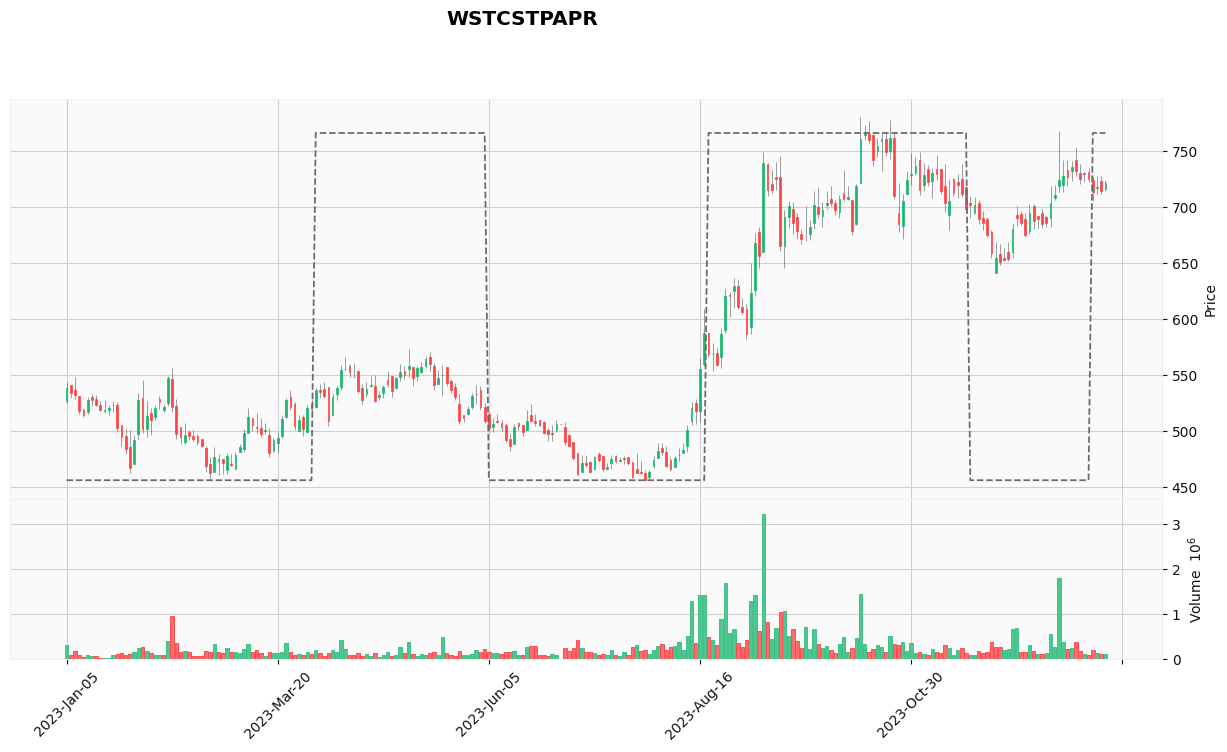

In [13]:
import mplfinance as mpf

where_values1 = df['F_Flag'].values == 'G'
where_values2 = df['F_Flag'].values == 'R'

apds = [ mpf.make_addplot(df['G_Close'], color='dimgrey', linestyle='dashed')
      ]
cols = ['Open', 'Close', 'Low', 'High', 'Volume']
# Plot the candlestick chart with volume
mpf.plot(df[cols], type='candle', style='yahoo', volume=True, addplot=apds, figsize=(16, 8), title=symbol )

# If you want to save the plot to a file, use the following line
# mpf.plot(df, type='candle', style='yahoo', volume=True, title='Candlestick Chart with Volume', savefig='chart.png')

mpf.show()